You can find the data here: https://data.boston.gov/dataset/vision-zero-entry

# Task1 - Data Cleaning  [10 points]

Load the data, visualize the class distribution. Clean up the target labels. Some categories have been arbitrarily split and need to be consolidated. 

### Import Libraries

In [31]:
%matplotlib inline

import numpy as np
from numpy import savetxt
import matplotlib.pyplot as plt
import sklearn
import pandas as pd 
import os
import csv
import math
import nltk
import re
import itertools

from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.decomposition import NMF
from sklearn.metrics import adjusted_rand_score
#nltk.download('all', halt_on_error=False)

### Load Data

In [4]:
# Add your code for task 1 here. You may use multiple cells. 
data_path = os.path.join("data/Vision_Zero_Entry.csv")
data = pd.read_csv(data_path, index_col=False, header=0)
data.head()


,﻿X,Y,OBJECTID,GLOBALID,REQUESTID,REQUESTTYPE,REQUESTDATE,STATUS,STREETSEGID,COMMENTS,USERTYPE
0,-71.071329,42.332161,15607,NaN,15607.0,bike facilities don't exist or need improvement,2016-01-19T22:14:26.000Z,Unassigned,0,the roadway is super wide here with no lane ma...,bikes
1,-71.067764,42.374244,15608,NaN,15608.0,"the wait for the ""Walk"" signal is too long",2016-01-19T22:55:29.000Z,Unassigned,0,As someone who walks from SE of the intersecti...,walks
2,-71.066077,42.374768,15609,NaN,15609.0,people cross away from the crosswalks,2016-01-19T22:57:09.000Z,Unassigned,0,I'm one of those people. Many people walk nort...,walks
3,-71.152978,42.345312,16007,NaN,16007.0,people speed,2016-01-19T23:33:20.000Z,Unassigned,0,NaN,walks
4,-71.070658,42.351921,16008,NaN,16008.0,people don't yield while turning,2016-01-19T23:39:45.000Z,Unassigned,0,People do not understand which lane to move in...,drives


We can see that there are 11 columns in this dataset. In order to simplify the analysis, we will just be using 2 columns: REQUESTTYPE, which indicates the category of complaints, and COMMENTS, which indicates the actual comment of the complainants. 

### Checkout Target Variable & Clean Target Variable

Checkout what values does the target variable have currently. Replace those with "src" in them with the actual comment and remove the picture. Combine similar values of target variable together (manually)

In [5]:
for request in set(data.REQUESTTYPE.values):
    print(request)

" src="images/12 - Bike facility issue.png"></span>&nbsp;the roadway surface needs improvement
people have to wait too long for the "Walk" signal
of something that is not listed here
it’s hard to see / low visibility
people run red lights / stop signs
" src="images/14 - Other issue.png"></span>&nbsp;of something that is not listed here
people are not given enough time to cross the street
people cross away from the crosswalks
people speed
there are no sidewalks or they need maintenance
" src="images/02 - Wait is too long.png"></span>&nbsp;the wait for the "Walk" signal is too long
there are no bike facilities or they need maintenance
" src="images/11 - Sidewalk issue.png"></span>&nbsp;sidewalks/ramps don't exist or need improvement
sidewalks/ramps don't exist or need improvement
" src="images/06 - Speeding.png"></span>&nbsp;people speed
the roadway surface needs maintenance
people don't yield while turning
" src="images/10 - Hard to see.png"></span>&nbsp;it’s hard to see / low visibilit

In [6]:
for i in range(1,data.shape[0]):
    if "src" in data.iloc[i,5]:
        data.iloc[i,5] = data.iloc[i,5].split(";")[1]

In [7]:
for request in set(data.REQUESTTYPE.values):
    print(request)

people speed
there are no sidewalks or they need maintenance
it’s hard to see / low visibility
people run red lights / stop signs
there are no bike facilities or they need maintenance
the roadway surface needs improvement
there's not enough time to cross the street
people double park their vehicles
sidewalks/ramps don't exist or need improvement
it’s hard for people to see each other
people don't yield while going straight
the roadway surface needs maintenance
people don't yield while turning
people have to cross too many lanes / too far
the wait for the "Walk" signal is too long
it's too far / too many lanes to cross
bike facilities don't exist or need improvement
people have to wait too long for the "Walk" signal
people are not given enough time to cross the street
people cross away from the crosswalks
of something that is not listed here


In [8]:
for i in range(1,data.shape[0]):
    if "roadway" in data.iloc[i,5]:
        data.iloc[i,5] = "the roadway surface needs maintenance"
    elif "sidewalks" in data.iloc[i,5]:
        data.iloc[i,5] = "sidewalks/ramps don't exist or need improvement"
    elif "too many" in data.iloc[i,5]:
        data.iloc[i,5] = "people have to cross too many lanes / too far"
    elif "enough time" in data.iloc[i,5]:
        data.iloc[i,5] = "people are not given enough time to cross the street"
    elif "bike facilities" in data.iloc[i,5]:
        data.iloc[i,5] = "bike facilities don't exist or need improvement"
    elif "too long" in data.iloc[i,5]:
        data.iloc[i,5] = "people have to wait too long for the \"Walk\" signal"
    elif "to see" in data.iloc[i,5]:
        data.iloc[i,5] = "it’s hard for people to see each other"

In [9]:
for request in set(data.REQUESTTYPE.values):
    print(request)

people speed
people run red lights / stop signs
sidewalks/ramps don't exist or need improvement
it’s hard for people to see each other
people don't yield while going straight
the roadway surface needs maintenance
people don't yield while turning
people have to cross too many lanes / too far
people double park their vehicles
bike facilities don't exist or need improvement
people have to wait too long for the "Walk" signal
people are not given enough time to cross the street
people cross away from the crosswalks
of something that is not listed here


### Further Clean-up Data by Removing NaN and Deleting Irrelevant Columns

In [10]:
for i in range(1,data.shape[0]):
    if isinstance(data.iloc[i,9], float):
        data.iloc[i,9] = ""

In [11]:
data.shape

(8542, 11)

In [12]:
del data["OBJECTID"]
del data["GLOBALID"]
del data["REQUESTID"]
del data["STATUS"]
del data["STREETSEGID"]
data.head()

,﻿X,Y,REQUESTTYPE,REQUESTDATE,COMMENTS,USERTYPE
0,-71.071329,42.332161,bike facilities don't exist or need improvement,2016-01-19T22:14:26.000Z,the roadway is super wide here with no lane ma...,bikes
1,-71.067764,42.374244,"people have to wait too long for the ""Walk"" si...",2016-01-19T22:55:29.000Z,As someone who walks from SE of the intersecti...,walks
2,-71.066077,42.374768,people cross away from the crosswalks,2016-01-19T22:57:09.000Z,I'm one of those people. Many people walk nort...,walks
3,-71.152978,42.345312,people speed,2016-01-19T23:33:20.000Z,,walks
4,-71.070658,42.351921,people don't yield while turning,2016-01-19T23:39:45.000Z,People do not understand which lane to move in...,drives


In [13]:
model_data = data[["REQUESTTYPE", "COMMENTS"]]
model_data.head()

,REQUESTTYPE,COMMENTS
0,bike facilities don't exist or need improvement,the roadway is super wide here with no lane ma...
1,"people have to wait too long for the ""Walk"" si...",As someone who walks from SE of the intersecti...
2,people cross away from the crosswalks,I'm one of those people. Many people walk nort...
3,people speed,
4,people don't yield while turning,People do not understand which lane to move in...


### Distribution of Target Variable

In [14]:
target_freq = model_data.REQUESTTYPE.value_counts()

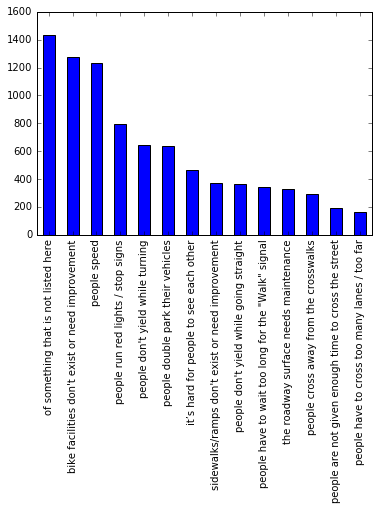

In [15]:
target_freq.plot.bar()

The biggest category with over 1400 comments are in the 'Not Listed Category'. This means there are definitely room for improvement/better categories here. 

### De-duping Duplicate Rows

In [16]:
model_data.shape

(8542, 2)

In [17]:
model_data = model_data.drop_duplicates()

In [18]:
model_data.shape

(6478, 2)

### Pre-process Words 

Remove punctuation off sentences. Convert all the words into their stem form. Lowercase all the letters in the word. 

In [19]:
dataX = model_data.ix[:,1]
dataY = model_data.ix[:,0]

In [20]:
stemmer = SnowballStemmer("english")
#stemmer = WordNetLemmatizer()

In [21]:
dataX.head()

0    the roadway is super wide here with no lane ma...
1    As someone who walks from SE of the intersecti...
2    I'm one of those people. Many people walk nort...
3                                                     
4    People do not understand which lane to move in...
Name: COMMENTS, dtype: object

In [22]:
dataX = dataX.str.replace('[^\w\s]','')

In [23]:
dataX.head()

0    the roadway is super wide here with no lane ma...
1    As someone who walks from SE of the intersecti...
2    Im one of those people Many people walk north ...
3                                                     
4    People do not understand which lane to move in...
Name: COMMENTS, dtype: object

In [24]:
dataX = dataX.str.lower()

In [25]:
dataX.head()

0    the roadway is super wide here with no lane ma...
1    as someone who walks from se of the intersecti...
2    im one of those people many people walk north ...
3                                                     
4    people do not understand which lane to move in...
Name: COMMENTS, dtype: object

In [26]:
def stem_word(phrase):
    return " ".join([stemmer.stem(word) for word in word_tokenize(phrase)])

In [29]:
stemmed_dataX = dataX.copy()
stemmed_dataX = stemmed_dataX.apply(stem_word)

In [32]:
stemmed_dataX.head()

0    the roadway is super wide here with no lane ma...
1    as someon who walk from se of the intersect i ...
2    im one of those peopl mani peopl walk north th...
3                                                     
4    peopl do not understand which lane to move int...
Name: COMMENTS, dtype: object

# Task2 - Model 1

Run a baseline multi-class classification model using a bag-of-word approach, report macro f1-score (should be above .5) and visualize the confusion matrix. Can you interpret the mistakes made by the model? 

### Bag of Word Approach

In [33]:
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, stratify=dataY)

In [34]:
x_stem_train, x_test, y_stem_train, y_test = train_test_split(stemmed_dataX, dataY, stratify=dataY)

In [35]:
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, stratify=dataY)
vectorizer = CountVectorizer(stop_words="english", lowercase=True)
x_train_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

In [36]:
x_train_vectorized

<4858x6092 sparse matrix of type '<class 'numpy.int64'>'
	with 58324 stored elements in Compressed Sparse Row format>

In [37]:
# Add your code for task 2 here. You may use multiple cells. 
lr = LogisticRegression().fit(x_train_vectorized, y_train)

y_test_pred = lr.predict(x_test_vectorized)

### F1-Score for Bag of Word Approach

In [38]:
f1_score(y_test, y_test_pred, average="macro")

0.55451574383584334

Using the very simple Bag of Word Approach, we obtained a .55 F1 Score. We will try improving this score using additional methods such as TFIDF and N-grams.

### Confusion Matrix and Visualization

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{0:.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[158   4   1   1   6   0   2   0   0   3   0   0   2   9]
 [ 11 120   0   0   1   0   3   0   1   1   0   0   2  24]
 [  6   0  51   1   1   0   0   0   0   4   1   0   7  14]
 [ 14   3   3  34   1   1   0   0   3   3   0   0   2  39]
 [ 10   2   1   0  25   3   2   0   0   1   2   0   5  13]
 [  6   0   2   0   2  18   1   1   0  15   1   0   1  16]
 [  5   3   0   2  12   0  41   1   0   7   2   1   1  38]
 [  3   2   0   0   0   1   0   8   1   1   0   0   0  11]
 [  2   1   0   0   0   0   1   0  42  10   0   0   1  49]
 [  3   2   2   0   1   4   1   0   4 161   1   0   0  26]
 [  3   2   0   0   0   0   2   0   0   0  33   4   0  13]
 [  2   3   0   0   0   0   2   0   0   0   1  16   0   9]
 [  2   0   3   0   2   0   0   1   0   0   2   3  33  18]
 [ 12   9  12   0   7   6   8   1   4  30   8   3   9 242]]


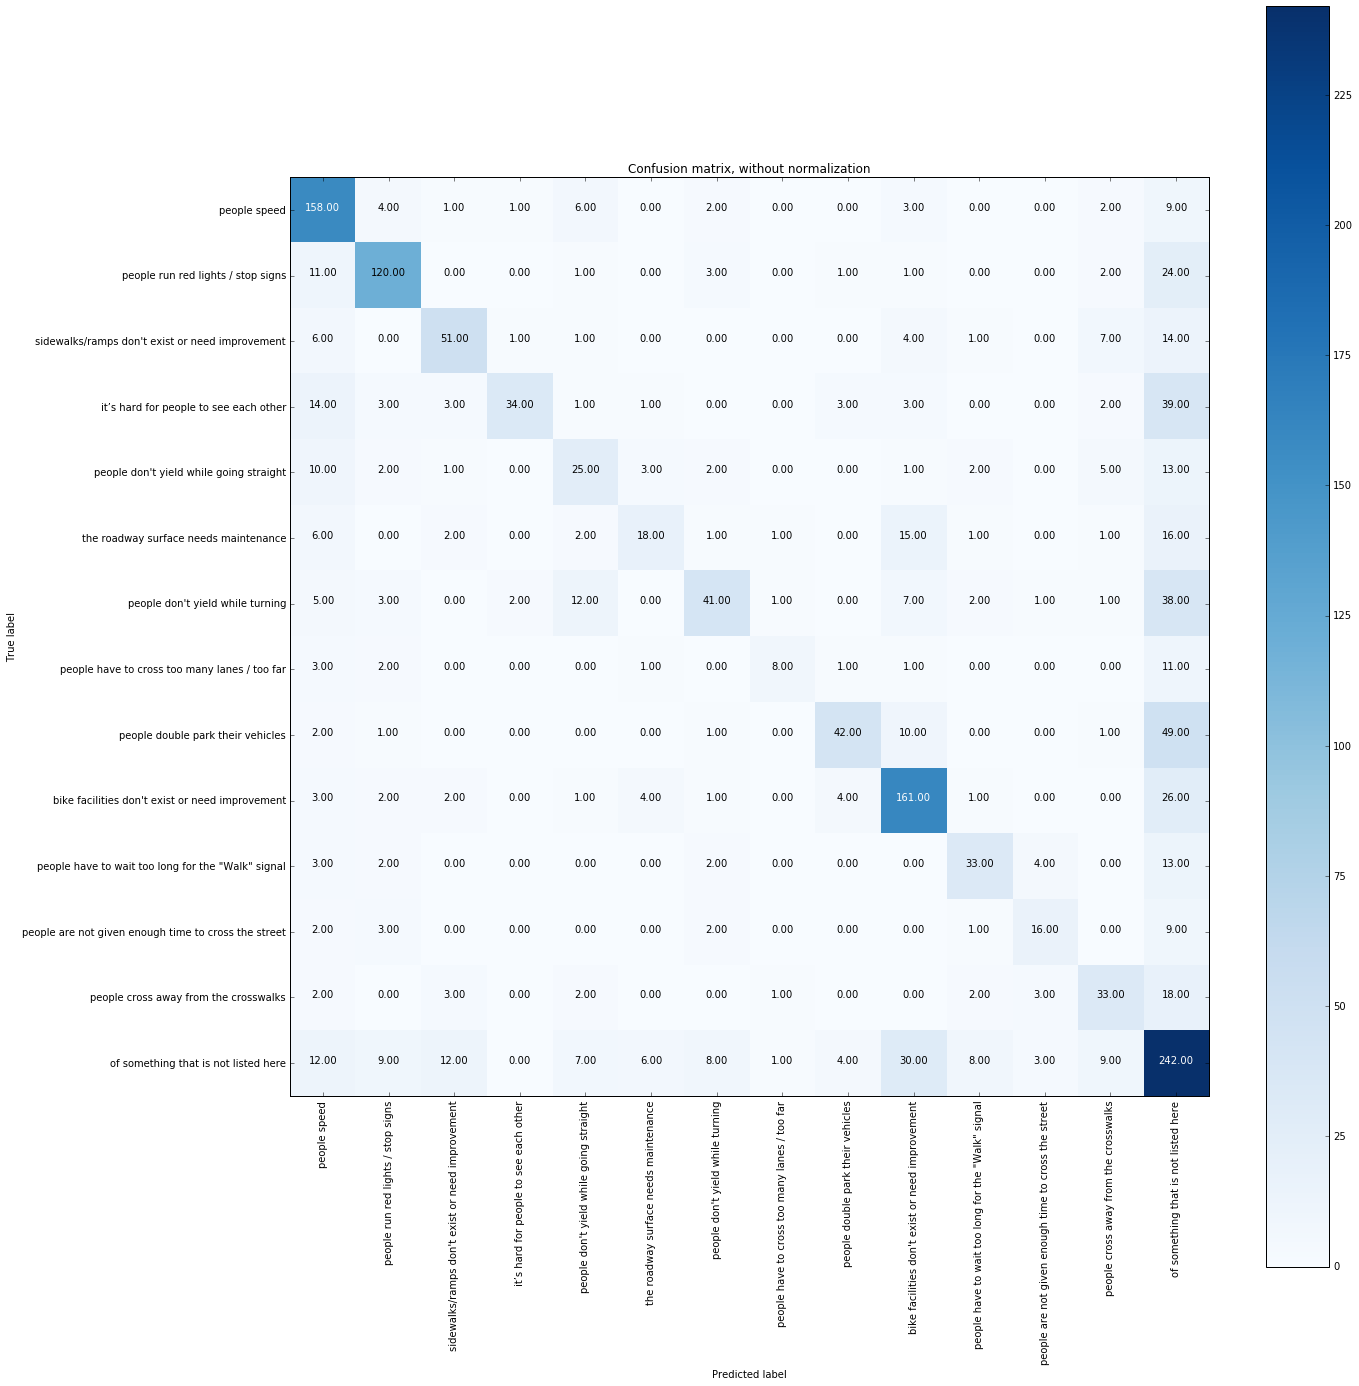

In [43]:
np.set_printoptions(precision=2)
basic_confus_mat = confusion_matrix(y_test, y_test_pred, labels=list(set(model_data.REQUESTTYPE.values)))

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(basic_confus_mat, classes=list(set(model_data.REQUESTTYPE.values)),
                      title='Confusion matrix, without normalization')


# Task3 - Model 2: N-grams, TFIDF

Improve the model using more complex text features, including n-grams, character n-grams and possibly domain-specific features.

### Trying N-grams Model 

In [44]:
vectorizer_ngrams = CountVectorizer(ngram_range=(1,10), stop_words="english", lowercase=True, min_df=2)
x_train_vectorized_ngrams = vectorizer_ngrams.fit_transform(x_train)
x_test_vectorized_ngrams = vectorizer_ngrams.transform(x_test)


In [45]:
x_train_vectorized_ngrams

<4858x13628 sparse matrix of type '<class 'numpy.int64'>'
	with 94287 stored elements in Compressed Sparse Row format>

In [46]:
x_test_vectorized_ngrams

<1620x13628 sparse matrix of type '<class 'numpy.int64'>'
	with 19602 stored elements in Compressed Sparse Row format>

In [47]:
lr_ngrams = LogisticRegression().fit(x_train_vectorized_ngrams, y_train)

y_test_pred_ngrams = lr_ngrams.predict(x_test_vectorized_ngrams)

In [48]:
f1_score(y_test, y_test_pred_ngrams, average="macro")

0.59785954047220613

We get a better score here using n-grams model, at near .6 instead of .55 using Bag of Words.

Confusion matrix, without normalization
[[154   3   1   1   3   0   2   0   0   4   0   0   1  17]
 [  6 126   1   0   0   0   1   0   1   0   0   0   2  26]
 [  5   0  59   0   0   0   0   0   0   4   1   0   6  10]
 [ 10   4   1  41   0   0   3   0   1   2   0   0   2  39]
 [  8   1   1   0  25   0   2   0   0   1   2   0   4  20]
 [  5   0   0   0   1  21   1   1   0  15   1   1   2  15]
 [  6   3   0   1   7   0  43   1   0   9   2   0   2  39]
 [  4   1   1   0   0   2   0   7   1   1   0   0   0  10]
 [  3   1   0   0   0   0   1   0  37   8   0   0   1  55]
 [  3   2   1   0   1   3   1   0   1 170   0   1   0  22]
 [  2   2   0   0   0   0   1   0   0   0  38   4   0  10]
 [  2   3   0   0   0   1   0   0   0   0   0  21   0   6]
 [  2   0   3   0   0   0   0   0   0   0   2   3  36  18]
 [  9  11  11   1   2   3   6   1   0  26   7   1  13 260]]


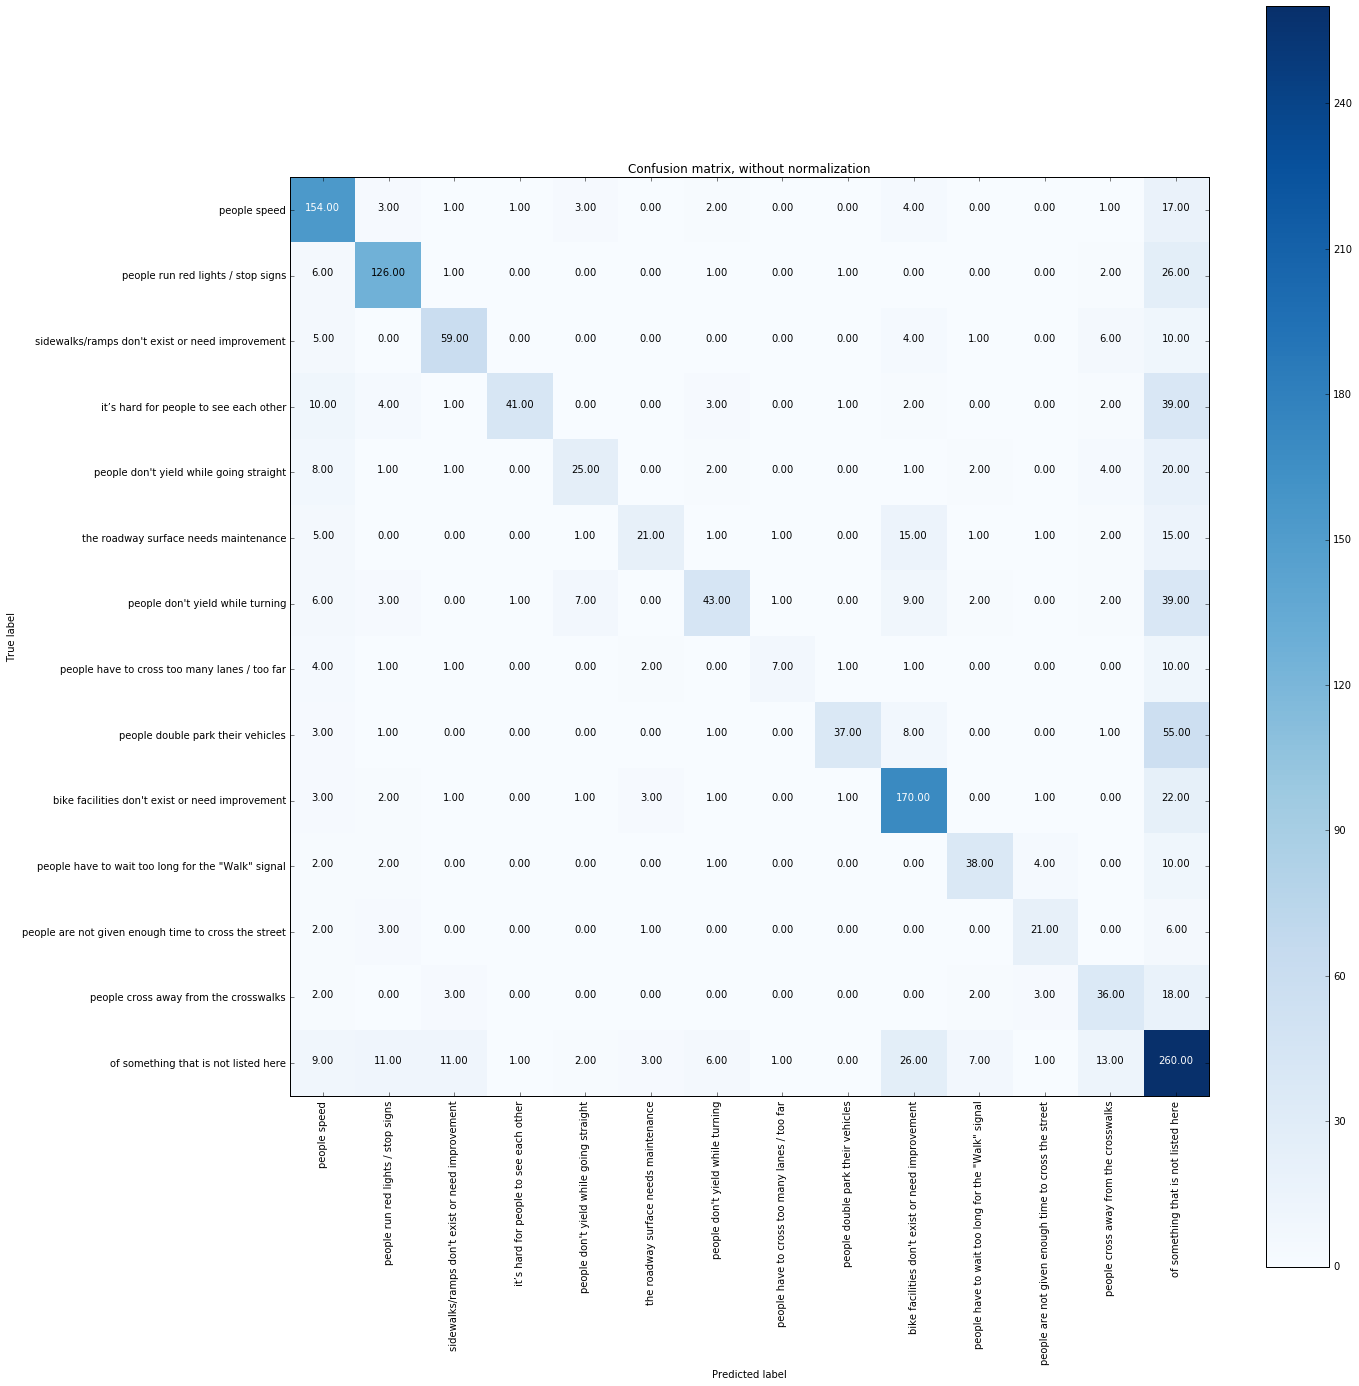

In [49]:
confus_mat_ngrams = confusion_matrix(y_test, y_test_pred_ngrams, labels=list(set(model_data.REQUESTTYPE.values)))

plt.figure(figsize=(20,20))
plot_confusion_matrix(confus_mat_ngrams, classes=list(set(model_data.REQUESTTYPE.values)),
                      title='Confusion matrix, without normalization')


### Trying TF-IDF Model

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

tfidf_model = TfidfVectorizer(ngram_range=(1,10), stop_words="english", lowercase=True, min_df=15).fit(x_train)
x_train_tfidf = tfidf_model.transform(x_train)
x_test_tfidf = tfidf_model.transform(x_test)

In [51]:
lr_tfidf = LogisticRegression().fit(x_train_tfidf, y_train)

y_test_pred_tfidf = lr_tfidf.predict(x_test_tfidf)

In [52]:
f1_score(y_test, y_test_pred_tfidf, average="macro")

0.47439849425618558

Confusion matrix, without normalization
[[136   8   0   2   2   1   3   0   0   6   0   0   1  27]
 [  6 117   0   0   0   0   2   0   0   1   0   0   2  35]
 [  6   0  45   1   0   0   0   0   0   5   1   0   7  20]
 [ 10   5   1  28   0   0   1   0   1   3   0   0   2  52]
 [  8   2   0   0  11   0   5   0   0   2   2   0   5  29]
 [  4   0   1   0   0   8   0   0   0  21   1   0   2  26]
 [  4   3   0   2   6   0  31   0   0   9   4   0   1  53]
 [  3   1   2   0   0   1   1   2   0   1   0   0   1  15]
 [  3   2   0   0   0   0   0   0  29  10   0   0   0  62]
 [  5   3   1   0   0   0   1   0   1 161   0   0   2  31]
 [  1   1   0   0   0   0   1   0   0   0  37   2   0  15]
 [  3   4   0   0   0   0   1   0   0   0   1  12   0  12]
 [  1   1   3   0   0   0   0   0   0   0   2   0  29  28]
 [ 10  19  11   3   4   2   4   0   3  34   6   0  12 243]]


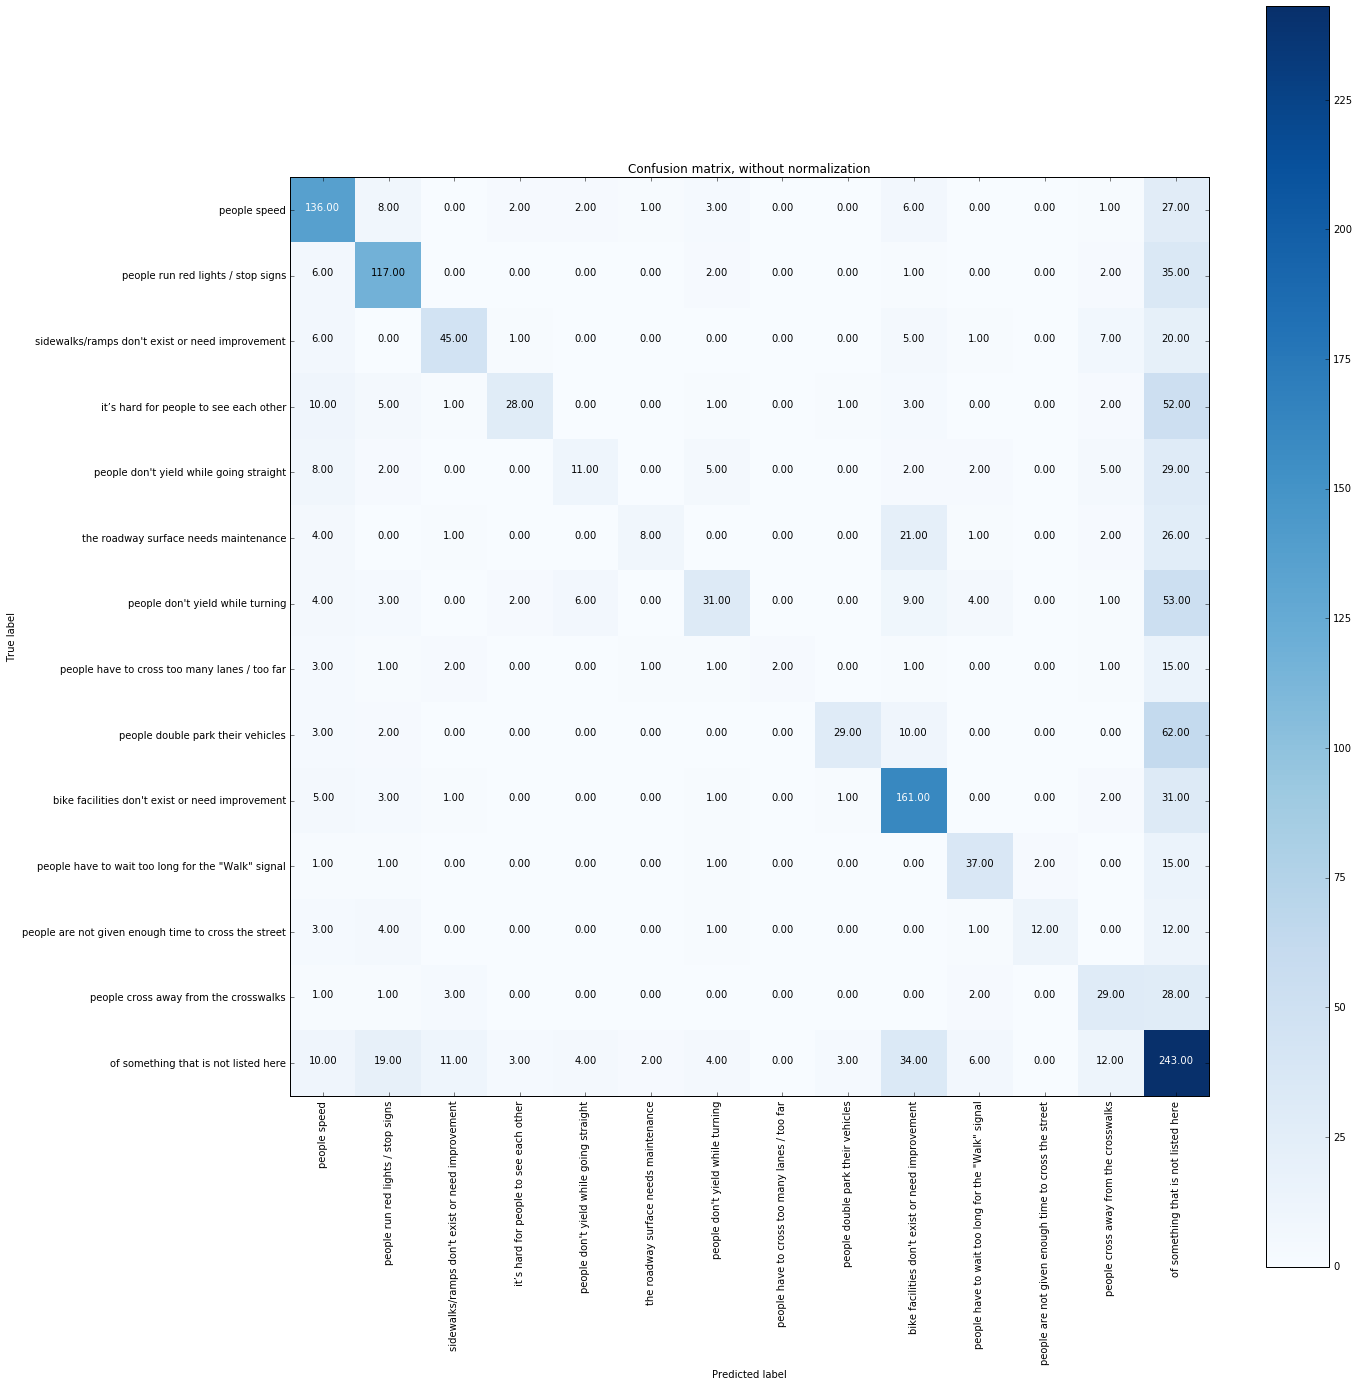

In [53]:
confus_mat_tfidf = confusion_matrix(y_test, y_test_pred_tfidf, labels=list(set(model_data.REQUESTTYPE.values)))
plt.figure(figsize=(20,20))
plot_confusion_matrix(confus_mat_tfidf, classes=list(set(model_data.REQUESTTYPE.values)),
                      title='Confusion matrix, without normalization')

In [54]:
tfidf_transformer_model = TfidfTransformer()
tfidf_transformer_model.fit(x_train_vectorized_ngrams)
x_train_tfidf2 = tfidf_transformer_model.transform(x_train_vectorized_ngrams)
x_test_tfidf2 = tfidf_transformer_model.transform(x_test_vectorized_ngrams)

In [55]:
lr_tfidf2 = LogisticRegression().fit(x_train_tfidf2, y_train)

y_test_pred_tfidf2 = lr_tfidf2.predict(x_test_tfidf2)

In [56]:
f1_score(y_test, y_test_pred_tfidf2, average="macro")

/Users/hoadang/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.44858612643703732

Confusion matrix, without normalization
[[138   9   0   1   2   0   1   0   0   4   0   0   1  30]
 [  3 124   0   0   0   0   2   0   0   1   0   0   1  32]
 [  6   1  46   1   0   0   0   0   0   4   1   0   6  20]
 [ 11   5   1  17   0   0   1   0   1   4   0   0   2  61]
 [  7   4   0   0  10   0   4   0   0   2   2   0   6  29]
 [  6   1   0   0   0   9   0   0   0  19   1   0   1  26]
 [  4   4   0   2   2   0  24   0   0   8   4   0   0  65]
 [  4   1   1   0   0   0   0   0   0   1   0   0   3  17]
 [  3   2   0   0   0   0   0   0  22  17   0   0   0  62]
 [  3   3   1   0   0   0   0   0   1 173   0   0   0  24]
 [  3   2   0   0   0   0   1   0   0   0  36   1   0  14]
 [  4   4   0   0   0   0   1   0   0   0   2  10   0  12]
 [  2   2   2   0   0   0   0   0   0   0   3   0  27  28]
 [ 10  22   8   1   3   0   0   0   1  34   8   0   5 259]]


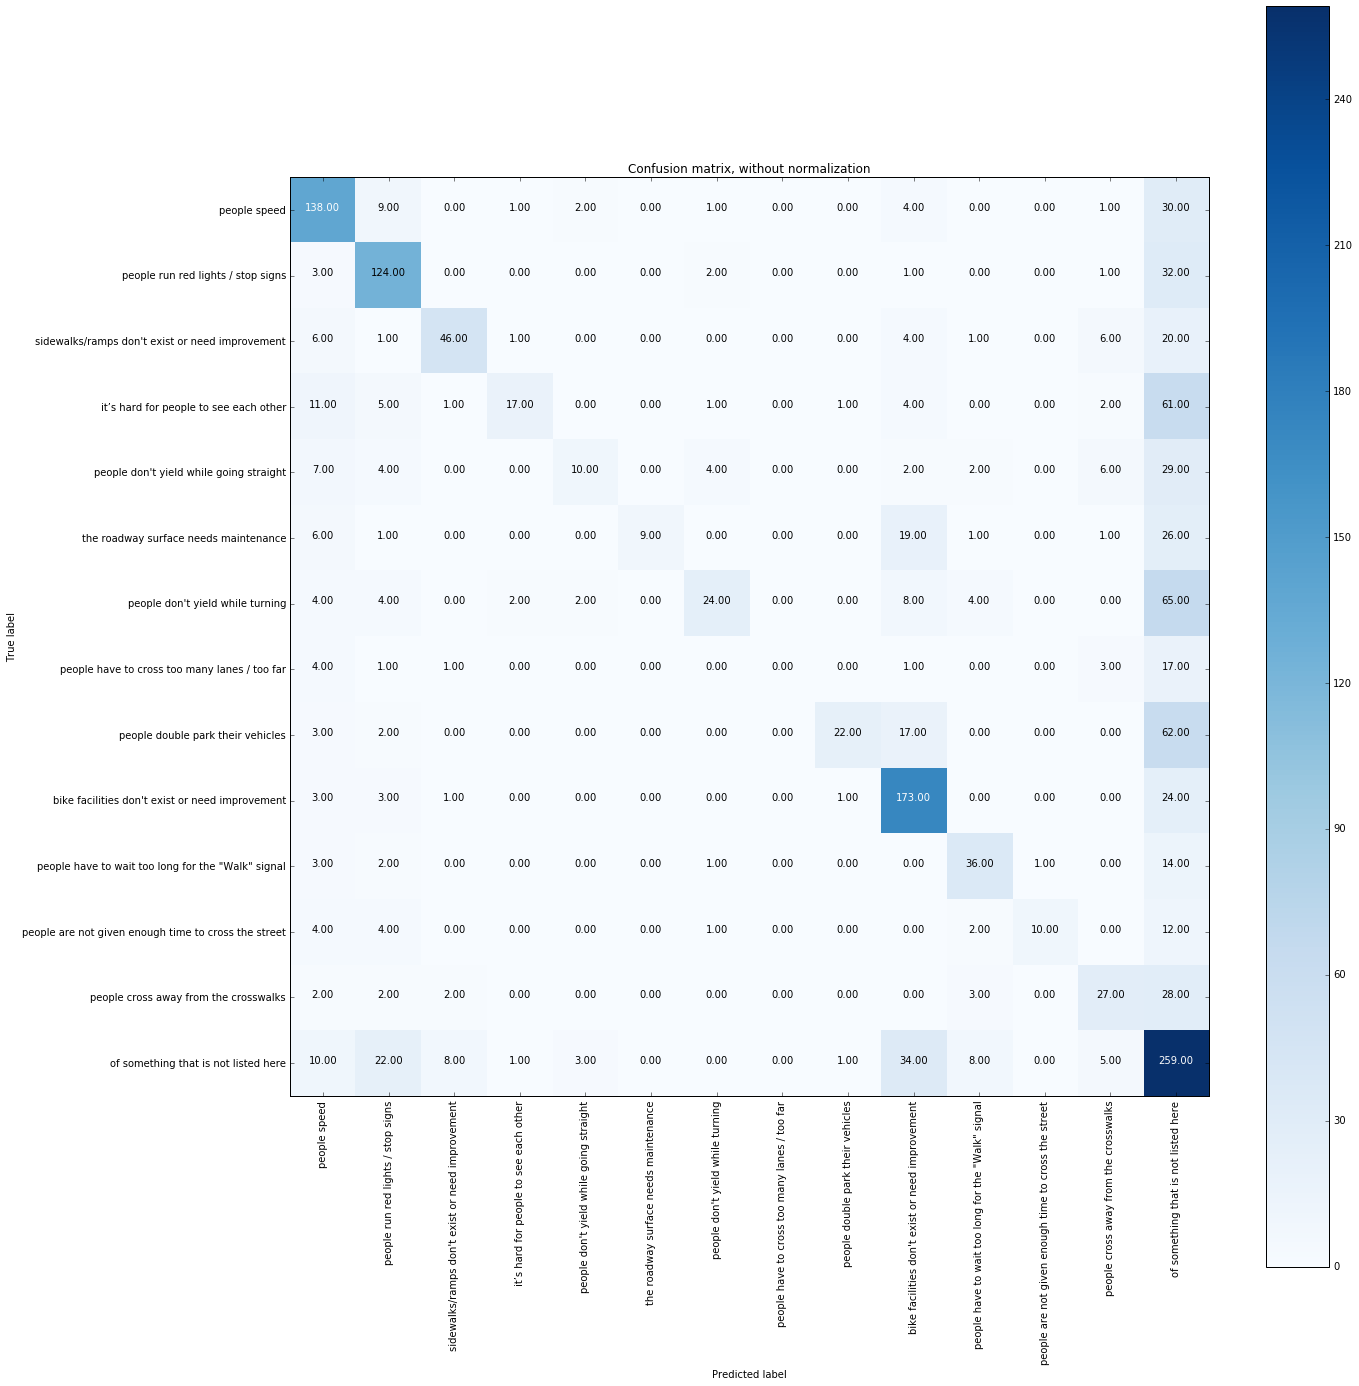

In [57]:
confus_mat_tfidf2 = confusion_matrix(y_test, y_test_pred_tfidf2, labels=list(set(model_data.REQUESTTYPE.values)))
plt.figure(figsize=(20,20))
plot_confusion_matrix(confus_mat_tfidf2, classes=list(set(model_data.REQUESTTYPE.values)),
                      title='Confusion matrix, without normalization')

OH MY GOD!!! TFIDF Score is ABYSMAL!! At .44, which is 10 points lower than Bag of Words. Let's try Character N-grams, where I break up the words into characters. Characters N-grams help the model to be less susceptible to misspelling. 

### Trying Character N-grams Model

In [58]:
vectorizer_char_ngrams = CountVectorizer(ngram_range=(1,10), stop_words="english", analyzer="char_wb", lowercase=True, min_df=5)
x_train_vectorized_char_ngrams = vectorizer_char_ngrams.fit_transform(x_train)
x_test_vectorized_char_ngrams = vectorizer_char_ngrams.transform(x_test)

In [59]:
lr_char_ngrams = LogisticRegression().fit(x_train_vectorized_char_ngrams, y_train)
y_test_pred_char_ngrams = lr_char_ngrams.predict(x_test_vectorized_char_ngrams)

In [60]:
best_score = f1_score(y_test, y_test_pred_char_ngrams, average="macro")

In [61]:
best_score

0.73769134829554461

In [64]:
#confus_mat_char_ngrams = confusion_matrix(y_test, y_test_pred_char_ngrams, labels=list(set(model_data.REQUESTTYPE.values)))
#plt.figure(figsize=(20,20))
#plot_confusion_matrix(confus_mat_char_ngrams, classes=list(set(model_data.REQUESTTYPE.values)),
#                      title='Confusion matrix, without normalization')

Looks like in this case, Character N-grams is our best bet. At F1 Score of .73, it beats all other models. 

# Task4 - Visualize Results [10 points]

Visualize results of the tuned model (classification results, confusion matrix, important features, example mistakes).

In [555]:
# Add your code for task 4 here. You may use multiple cells. 

def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    ax.bar(myrange, coef[important])
    ax.set_xticks(myrange)
    x_ticks = [feature_names[i] for i in important]
    ax.set_xticklabels(x_ticks, rotation=90, ha="right")
    

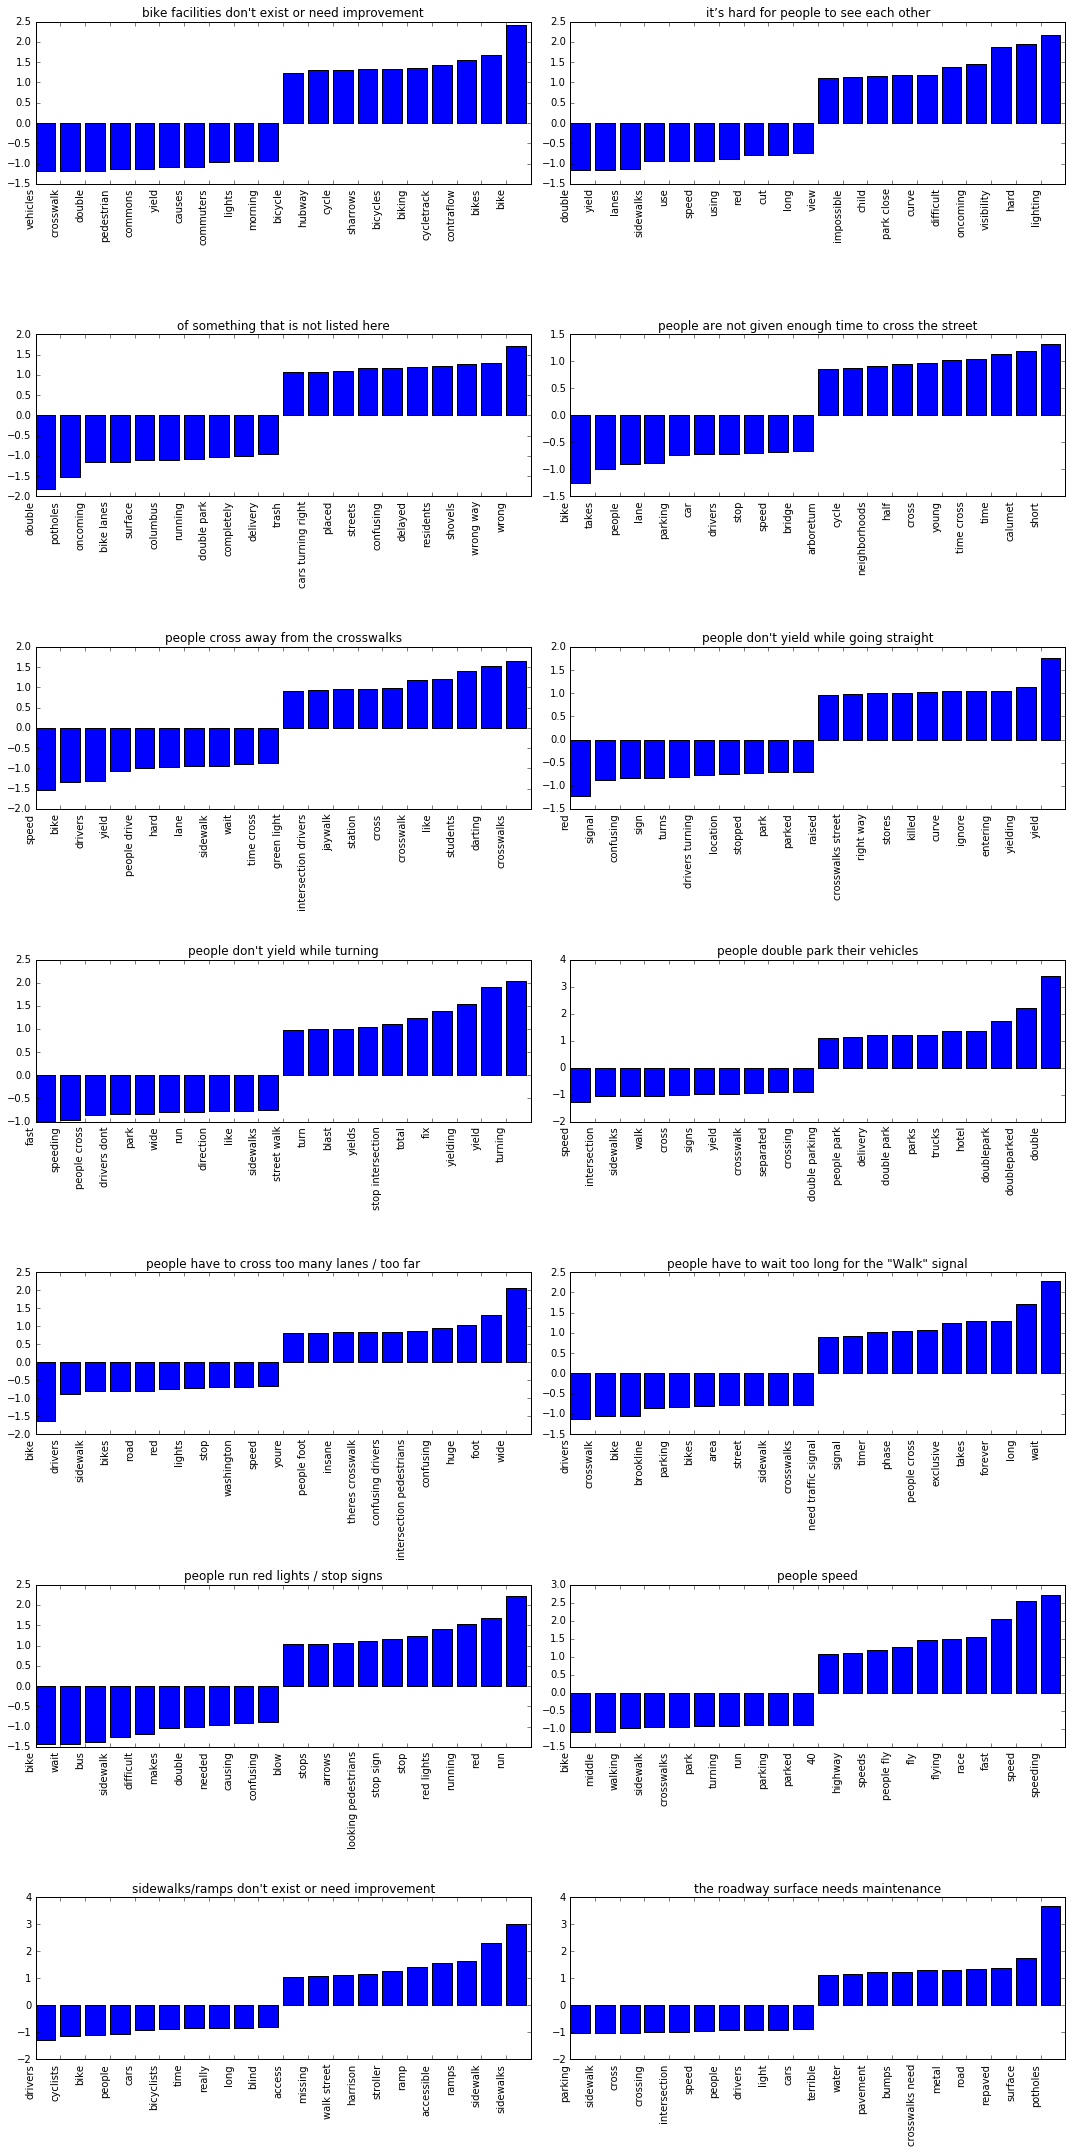

In [556]:
feature_names = vectorizer_ngrams.get_feature_names()
n_classes = len(set(dataY))
fig, axes = plt.subplots(n_classes // 2, 2, figsize=(15, 30))
for ax, coef, label in zip(axes.ravel(), lr_ngrams.coef_, lr_ngrams.classes_):
    ax.set_title(label)
    plt.subplots_adjust(hspace=1.5)
    plot_important_features(coef, feature_names, top_n=10, ax=ax)
    
plt.tight_layout()

# Task5 - Clustering: LDA, NMF

Apply LDA (LatentDirichletAllocation), NMF and K-Means to the whole dataset. Can we find clusters or topics that match well with some of the ground truth labels? Use ARI to compare the methods and visualize topics and clusters.

In [66]:
def print_topics(topics, feature_names, components, topics_per_chunk=6,
                 n_words=20):
    sorting = np.argsort(components, axis=1)[:, ::-1]
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, i]]))
            except:
                pass
        print("\n")


In [67]:
def plot_important_features(coef, feature_names, top_n=20, ax=None):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(np.abs(coef))[-top_n:]
    important_coefs = coef[inds]
    sort_sign = np.argsort(important_coefs)
    myrange = range(len(inds))
    combined_inds = inds[sort_sign]

    ax.bar(myrange, coef[combined_inds])
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[combined_inds], rotation=60, ha="right")

In [69]:
#We are dropping NAN columns here
dataX_dropNA = dataX.replace('', np.nan, regex=True)
dataX_dropNA = dataX_dropNA.dropna()

In [70]:
dataX_dropNA= dataX_dropNA.reset_index(drop=True)

In [71]:
indexNan = np.argwhere(dataX=='')
indexNan = [item for sublist in indexNan for item in sublist]

In [72]:
dataY_dropNA = dataY.drop(dataY.index[indexNan])
dataY_dropNA = dataY_dropNA.reset_index(drop=True)

In [73]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
dataY_le = le.fit_transform(dataY_dropNA)

In [74]:
def ARIscore(transformed_X):
    df = pd.DataFrame(transformed_X)
    topics = df.idxmax(axis=1)
    print(adjusted_rand_score(dataY_le, topics))
    return(adjusted_rand_score(dataY_le, topics))

## Trying LDA 

In [75]:
from sklearn.preprocessing import MaxAbsScaler, Normalizer
from sklearn.decomposition import LatentDirichletAllocation

In [76]:
vect = CountVectorizer(stop_words="english",min_df = 2 )
X_vec = vect.fit_transform(dataX_dropNA)

In [77]:
lda = LatentDirichletAllocation(n_topics=10, learning_method="batch")
X_lda = lda.fit_transform(X_vec)

In [78]:
ARIscore(X_lda)

0.0882576474953


0.088257647495346453

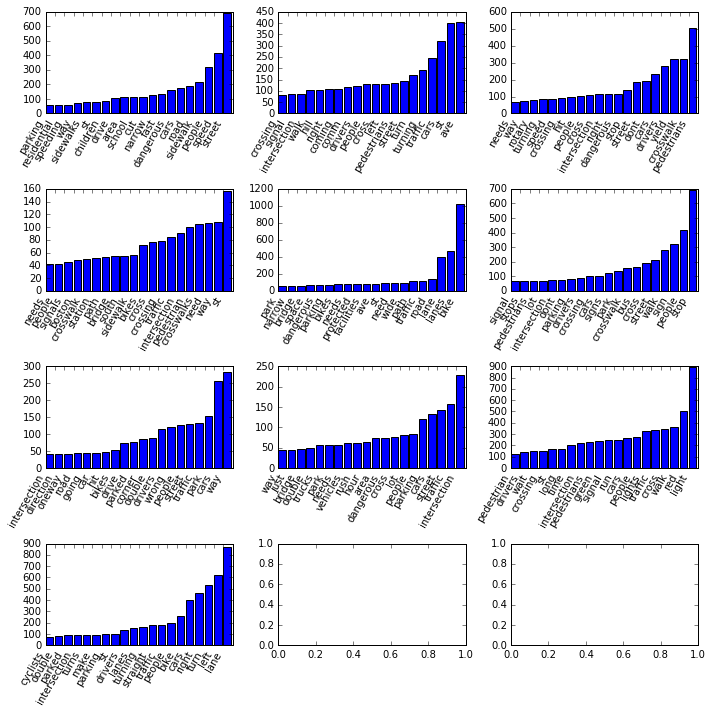

In [79]:
feature_names = np.array(vect.get_feature_names())
n_components = 10
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), lda.components_):
    plot_important_features(coef, feature_names, top_n=20, ax=ax)
    
plt.tight_layout()

In [80]:
topic_word = lda.components_
n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(feature_names)[np.argsort(topic_dist)][:-n_top_words:-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: street speed people sidewalk road cars dangerous fast narrow
Topic 1: ave st cars traffic turning turn street pedestrians left
Topic 2: pedestrians crosswalk yield drivers cars dont street stop dangerous
Topic 3: st way need crosswalks pedestrian intersection traffic crossing cross
Topic 4: bike lanes lane road traffic path wide need st
Topic 5: stop people sign walk street cross bus crosswalk park
Topic 6: way cars park traffic street people wrong drivers double
Topic 7: intersection traffic street cars parking people lot cross dangerous
Topic 8: light red walk cross traffic lights people cars run
Topic 9: lane left turn right cars bike people traffic straight


## LDA on Stemmed data

In [86]:
stemmed_dataX=stemmed_dataX.replace('', np.nan, regex=True).dropna()

In [87]:
stemmed_dataX=stemmed_dataX.reset_index(drop=True)

In [88]:
stemmed_X_vec = vect.fit_transform(stemmed_dataX)
lda_stemmed = LatentDirichletAllocation(n_topics=12, learning_method="batch")
X_lda_stemmed = lda_stemmed.fit_transform(stemmed_X_vec)

In [89]:
ARIscore(X_lda_stemmed)

0.0827447285004


0.082744728500446452

In [90]:
topic_word = lda_stemmed.components_
n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(feature_names)[np.argsort(topic_dist)][:-n_top_words:-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: children families canterbury arboretum centre complete cause accidents drivers comm ave dont collects assigned aware
Topic 1: coming arboretum centre blandford st children families boxes blocks blows collects ave need
Topic 2: change children families car pass canterbury arboretum centre comm ave dont ave especially dangerous bad angle ave need
Topic 3: collects blocked large chaptr bus passengers cars regularly blvd morton causes accidents cars regularly run canterbury
Topic 4: children families boston pedestrians car pass cause accidents drivers canterbury cars regularly arboretum centre change arent bike facilities
Topic 5: airport blocked large canterbury bad angle collects car pass ahead needs allows people come pressing
Topic 6: chestnut hill ave arboretum centre car pass causes accidents change baker bus passengers connect residents outlying bike tires
Topic 7: chestnut hill ave baker st bar cars speed bikers dont hit arboretum centre cars speed corner ave red beer
Topi

Our ARI or Adjusted Rand Score shows to be .08, which our topics does not really match the categories designated in the original data. Here, basically we want to compare the machine heuristic vs. human heuristic.

## LDA on ngrams 

In [81]:
cv_ngrams = CountVectorizer(ngram_range=(1,3),stop_words="english",min_df = 2)
lda_ngrams = LatentDirichletAllocation(n_topics=12, learning_method="batch")
X_ngram = cv_ngrams.fit_transform(dataX_dropNA)
X_ngram_lda = lda_ngrams.fit_transform(X_ngram)

In [82]:
ARIscore(X_ngram_lda)

0.047339589433


0.047339589432968718

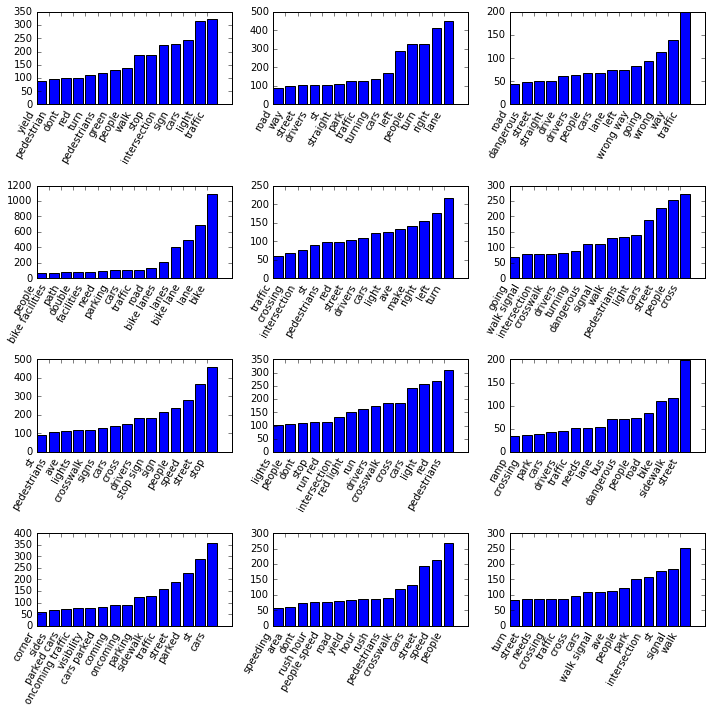

In [83]:
feature_names = np.array(cv_ngrams.get_feature_names())
n_components = 10
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), lda_ngrams.components_):
    plot_important_features(coef, feature_names,top_n=15, ax=ax)
    
plt.tight_layout()

In [84]:
feature_names = np.array(cv_ngrams.get_feature_names())
topic_word = lda_ngrams.components_
n_top_words = 12
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(feature_names)[np.argsort(topic_dist)][:-n_top_words:-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: traffic light cars sign intersection stop walk people green pedestrians turn
Topic 1: lane right turn people left cars turning traffic park straight st
Topic 2: traffic way wrong going wrong way left lane cars people drivers drive
Topic 3: bike lane bike lane lanes bike lanes road traffic cars parking need facilities
Topic 4: turn left right make ave light cars drivers street red pedestrians
Topic 5: cross people street cars light pedestrians walk signal dangerous turning drivers
Topic 6: stop street speed people sign stop sign drivers cross cars signs crosswalk
Topic 7: pedestrians red light cars cross crosswalk drivers run red light intersection run red
Topic 8: street sidewalk bike road people dangerous bus lane needs traffic drivers
Topic 9: cars st parked street traffic sidewalk parking oncoming coming cars parked visibility
Topic 10: people speed street cars crosswalk pedestrians rush hour yield road people speed
Topic 11: walk signal st intersection park people ave walk

## Trying NMF

## NFM on Stemmed data

In [91]:
nmf_scale_stemmed = NMF(n_components=10, verbose=10, tol=0.01)
X_stemmed_nmf_scale = nmf_scale_stemmed.fit_transform(stemmed_X_vec)

violation: 1.0
violation: 0.5347517617020376
violation: 0.34813059258796186
violation: 0.21918586305471496
violation: 0.15026164903972922
violation: 0.10366498754819696
violation: 0.06751678745895585
violation: 0.04323170456864321
violation: 0.02738893184451984
violation: 0.018995115719584805
violation: 0.014172404958214238
violation: 0.011017128637623889
violation: 0.008771520134076002
Converged at iteration 13


In [92]:
ARIscore(X_stemmed_nmf_scale)

0.0776145658593


0.077614565859286944

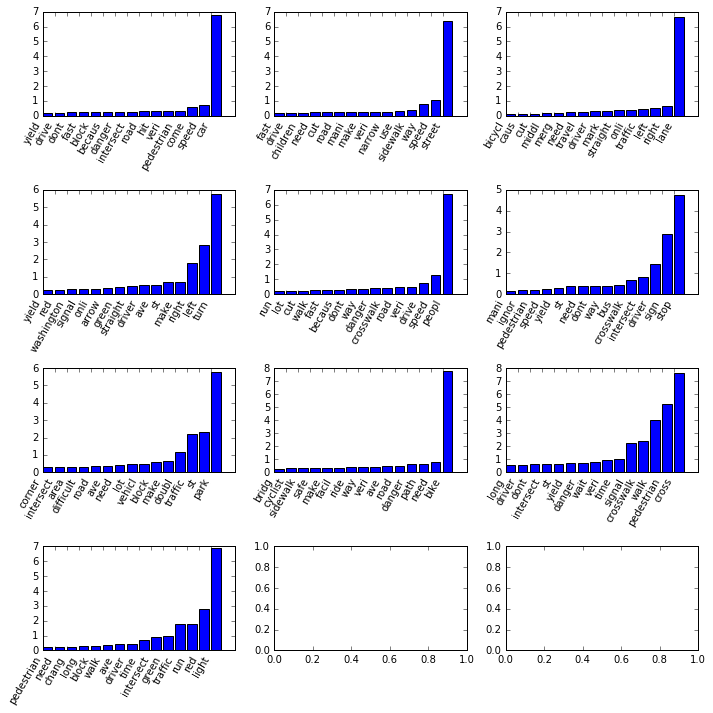

In [93]:
large_comp_inds = np.argsort(X_stemmed_nmf_scale.mean(axis=0))[-12:][::-1]

feature_names = np.array(vect.get_feature_names())
n_components = 10
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), nmf_scale_stemmed.components_[large_comp_inds, :]):
    plot_important_features(coef, feature_names, top_n=15, ax=ax)
    
plt.tight_layout()

In [94]:
topic_word = nmf_scale_stemmed.components_
n_top_words = 12
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(feature_names)[np.argsort(topic_dist)][:-n_top_words:-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: cross pedestrian walk crosswalk signal time veri wait danger yield st
Topic 1: lane right left traffic onli straight mark driver travel need merg
Topic 2: street speed way sidewalk use narrow veri make mani road cut
Topic 3: turn left right make st ave driver straight green arrow onli
Topic 4: car speed come pedestrian veri hit road intersect danger becaus block
Topic 5: stop sign driver intersect crosswalk bus way dont need st yield
Topic 6: peopl speed drive veri road crosswalk danger way dont becaus fast
Topic 7: light red run traffic green intersect time driver ave walk block
Topic 8: park st traffic doubl make block vehicl lot need ave road
Topic 9: bike need path danger road ave veri way ride facil make


## NMF on TFIDF

In [586]:
#from sklearn.feature_extraction.text import TfidfTransformer
#X_tfidf = TfidfTransformer().fit_transform(X_vec)
#nmf_tfidf = NMF(n_components=15, verbose=10, tol=0.01)
#X_nmf_tfidf = nmf_tfidf.fit_transform(X_tfidf)

In [101]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,3), stop_words="english", lowercase=True, min_df=2)
X_tfidf = tfidf_vect.fit_transform(dataX_dropNA)
nmf_tfidf = NMF(n_components=15, verbose=10, tol=0.01)
X_nmf_tfidf = nmf_tfidf.fit_transform(X_tfidf)

violation: 1.0
violation: 0.40319260350503455
violation: 0.2778748018005711
violation: 0.20694891525594844
violation: 0.16047088289714387
violation: 0.12832055543341842
violation: 0.10025762574902838
violation: 0.07653533358752049
violation: 0.059116793597903755
violation: 0.04669271285921884
violation: 0.038300424021471234
violation: 0.03206535007674192
violation: 0.02692956058651725
violation: 0.022702587389037507
violation: 0.019308377924965307
violation: 0.016517432444862153
violation: 0.014294972076597212
violation: 0.012502626369075488
violation: 0.011011823907462267
violation: 0.009788420581829476
Converged at iteration 20


In [102]:
ARIscore(X_nmf_tfidf)

0.0826436751346


0.082643675134604411

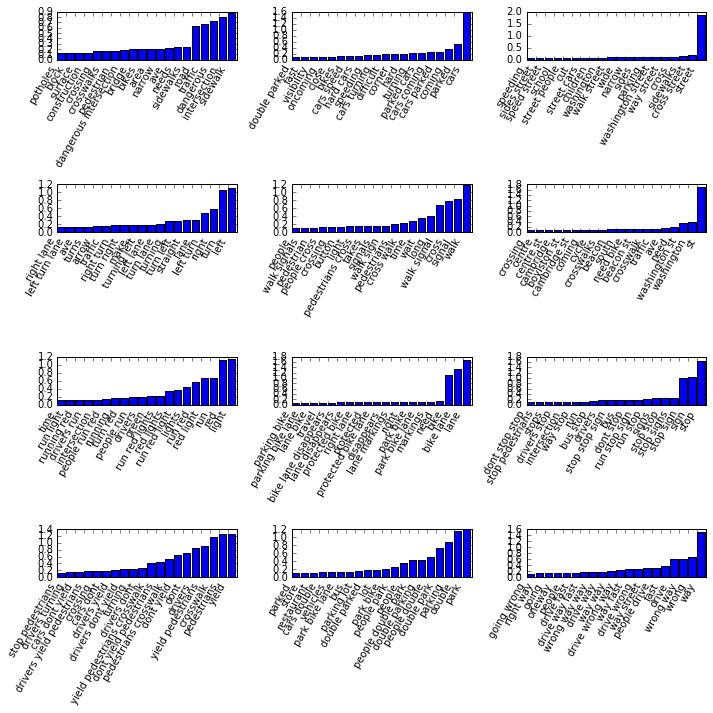

In [103]:
large_comp_inds = np.argsort(X_nmf_tfidf.mean(axis=0))[-12:][::-1]

feature_names = np.array(tfidf_vect.get_feature_names())
n_components = 10
fig, axes = plt.subplots(n_components // 3 + 1, 3, figsize=(10, 10))
for ax, coef in zip(axes.ravel(), nmf_tfidf.components_[large_comp_inds, :]):
    plot_important_features(coef, feature_names, top_n=20, ax=ax)
    
plt.tight_layout()

In [104]:
topic_word = nmf_tfidf.components_
n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(feature_names)[np.argsort(topic_dist)][:-n_top_words:-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: people speed people speed cut people drive drive speed limit limit people cross
Topic 1: lane bike lane bike need markings park bike lane park bike right lane markings
Topic 2: left turn right left turn lane straight turn left turning turn lane
Topic 3: stop sign stop sign stop signs stop stop signs run stop run stop sign dont stop
Topic 4: yield pedestrians crosswalk yield pedestrians drivers dont dont yield pedestrians crosswalk dont yield pedestrians
Topic 5: light red run red light run red lights run red light red lights run red lights
Topic 6: lanes bike lanes bike space needs bike lanes need needs bike needs space bike lanes
Topic 7: walk signal cross walk signal long wait time cross walk pedestrians
Topic 8: cars parked coming cars parked cars coming parked cars turning hard corner
Topic 9: park double parking double park people double double parking people double park people people park
Topic 10: st washington washington st need ave traffic crosswalk beacon st need bik

## K-means Clustering

In [591]:
from sklearn.cluster import KMeans
true_k = 10
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=10, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [592]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vect.get_feature_names()
for i in range(true_k):
    print ('Topic '+str(i))
    l=[]
    for ind in order_centroids[i, :10]:
        l.append(terms[ind])
    print ('%s' % ', '.join(map(str, l)))

Top terms per cluster:
Topic 0
red, light, red light, run, run red, lights, red lights, turn, run red light, cars
Topic 1
traffic, left, st, turn, lane, intersection, sidewalk, ave, drivers, lanes
Topic 2
walk, signal, walk signal, cross, long, wait, pedestrians, time, light, takes
Topic 3
bike, lane, bike lane, lanes, bike lanes, bike facilities, facilities, cars, need, road
Topic 4
people, speed, park, people speed, cross, street, double, double park, road, people cross
Topic 5
cars, parked, coming, intersection, traffic, turning, st, pedestrians, street, road
Topic 6
stop, stop sign, sign, stop signs, signs, stop stop, drivers, cars, run stop, people
Topic 7
crosswalk, yield, pedestrians, yield pedestrians, drivers, dont, dont yield, pedestrians crosswalk, cars, stop
Topic 8
street, parking, sidewalk, lot, people, traffic, double, double parking, speed, parking lot
Topic 9
way, wrong, wrong way, street, drive, way fast, way street, fast, people, drive wrong


In [598]:
assert(ARIscore(X_stemmed_nmf_scale)>.05)

0.077646717499


# Task6 - Topic Modeling

Improve the class definition for REQUESTTYPE by using the results of the clustering and results of the previous classification model. Re-assign labels using either the results of clustering or using keywords that you found during data exploration. The labels must be semantically meaningful.
The data has a large “other” category. Apply the topic modeling and clustering techniques to this subset of the data to find possible splits of this class.
Report accuracy using macro average f1 score (should be above .53) 


## LDA Clustering

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

In [96]:
lda = LatentDirichletAllocation(n_topics=15, learning_method="batch")
X_lda = lda.fit_transform(X_vec)
df = pd.DataFrame(X_lda)
lda_topics = df.idxmax(axis=1)
x_train, x_test, y_train, y_test = train_test_split(X_vec, lda_topics, stratify=lda_topics)

In [97]:
lr_ngrams = LogisticRegression().fit(x_train, y_train)
y_test_pred_ngrams = lr_ngrams.predict(x_test)
f1_score(y_test, y_test_pred_ngrams, average="macro")

0.6189622054255135

In [98]:
lda = LatentDirichletAllocation(n_topics=10, learning_method="batch")
X_lda = lda.fit_transform(X_vec)
df = pd.DataFrame(X_lda)
lda_topics = df.idxmax(axis=1)
x_train, x_test, y_train, y_test = train_test_split(X_vec, lda_topics, stratify=lda_topics)
lr_ngrams = LogisticRegression().fit(x_train, y_train)
y_test_pred_ngrams = lr_ngrams.predict(x_test)
f1_score(y_test, y_test_pred_ngrams, average="macro")

0.6783864576162294

In [99]:
#Grid Searching Topics
#for i in range(8,15):
#    lda = LatentDirichletAllocation(n_topics=i, learning_method="batch")
#    X_lda = lda.fit_transform(X_vec)
#    df = pd.DataFrame(X_lda)
#    lda_topics = df.idxmax(axis=1)
#    x_train, x_test, y_train, y_test = train_test_split(X_vec, lda_topics, stratify=lda_topics)
#    lr = LogisticRegression().fit(x_train, y_train)
#    y_test_pred = lr.predict(x_test)
#    print(str(i)+': '+str(f1_score(y_test, y_test_pred, average="macro")))

In [604]:
#LDA on X_ngram
#for i in range(8,15):
#    lda = LatentDirichletAllocation(n_topics=i, learning_method="batch")
#    X_lda = lda.fit_transform(X_ngram)
#    df = pd.DataFrame(X_lda)
#    lda_topics = df.idxmax(axis=1)
#    x_train, x_test, y_train, y_test = train_test_split(X_ngram, lda_topics, stratify=lda_topics)
#    lr = LogisticRegression().fit(x_train, y_train)
#    y_test_pred = lr.predict(x_test)
#    print(str(i)+': '+str(f1_score(y_test, y_test_pred, average="macro")))

8: 0.662426190024
9: 0.624215897448
10: 0.604285608194
11: 0.598570908267
12: 0.572492690798
13: 0.549128803678
14: 0.551922233483


## NFM Stemmed data

In [ ]:
#X_stemmed_nmf_scale
#for i in range(8,15):
#    nmf_tfidf = NMF(n_components=i, verbose=10, tol=0.01)
#    X_nmf_tfidf = nmf_tfidf.fit_transform(X_stemmed_nmf_scale)
#    df = pd.DataFrame(X_nmf_tfidf)
#    nmf_topics = df.idxmax(axis=1)
#    x_train, x_test, y_train, y_test = train_test_split(X_tfidf, nmf_topics, stratify=nmf_topics)
#    lr = LogisticRegression().fit(x_train, y_train)
#    y_test_pred = lr.predict(x_test)
#    print(str(i)+': '+str(f1_score(y_test, y_test_pred, average="macro")))
  

In [105]:
nmf_stemmed = NMF(n_components=10, verbose=10, tol=0.01)
X_nmf_stemmed = nmf_tfidf.fit_transform(X_stemmed_nmf_scale)
df = pd.DataFrame(X_nmf_stemmed)
nmf_topics = df.idxmax(axis=1)
x_train, x_test, y_train, y_test = train_test_split(X_stemmed_nmf_scale, nmf_topics, stratify=nmf_topics)
lr = LogisticRegression().fit(x_train, y_train)
y_test_pred = lr.predict(x_test)
f1_score(y_test, y_test_pred, average="macro")

violation: 1.0
violation: 0.48371252483035904
violation: 0.26495929394107615
violation: 0.1220410858301295
violation: 0.05410682969391644
violation: 0.027389118583898316
violation: 0.015623195158536453
violation: 0.00927980791652117
Converged at iteration 8


/Users/hoadang/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.56898907375714025

## NFM TFIDF

In [ ]:
#for i in range(8,15):
#    nmf_tfidf = NMF(n_components=i, verbose=10, tol=0.01)
#    X_nmf_tfidf = nmf_tfidf.fit_transform(X_tfidf)
#    df = pd.DataFrame(X_nmf_tfidf)
#    nmf_topics = df.idxmax(axis=1)
#    x_train, x_test, y_train, y_test = train_test_split(X_tfidf, nmf_topics, stratify=nmf_topics)
#    lr = LogisticRegression().fit(x_train, y_train)
#    y_test_pred = lr.predict(x_test)
#    print(str(i)+': '+str(f1_score(y_test, y_test_pred, average="macro")))
  

Best result for NFM TFIDF was 10 topics, print out will show many many lines as each time NMF fit the data  

In [106]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,4), stop_words="english", lowercase=True, min_df=2)
X_tfidf = tfidf_vect.fit_transform(dataX_dropNA)

In [107]:
nmf_tfidf = NMF(n_components=10, verbose=10, tol=0.01)
X_nmf_tfidf = nmf_tfidf.fit_transform(X_tfidf)
df = pd.DataFrame(X_nmf_tfidf)
nmf_topics = df.idxmax(axis=1)

violation: 1.0
violation: 0.45175678162397687
violation: 0.2740945759949865
violation: 0.17881153024540217
violation: 0.12726006047556304
violation: 0.09023195535634408
violation: 0.06674559967300765
violation: 0.05184216363365267
violation: 0.04242895659397232
violation: 0.036379958164725605
violation: 0.03225823031826627
violation: 0.02932937100281859
violation: 0.027236445049260507
violation: 0.025737516188819625
violation: 0.0246290724595287
violation: 0.023667840659663802
violation: 0.022732627860206498
violation: 0.021894531525599427
violation: 0.02095198693018321
violation: 0.02002919506182768
violation: 0.019066922600750425
violation: 0.018383915190140973
violation: 0.017891437460304194
violation: 0.01754328074645722
violation: 0.017241216698149472
violation: 0.016915078650947445
violation: 0.01657405508213519
violation: 0.01600503652817541
violation: 0.015141050826623478
violation: 0.01417504493562655
violation: 0.013034328504109122
violation: 0.01183058566937812
violation: 0.

In [108]:

x_train, x_test, y_train, y_test = train_test_split(X_tfidf, nmf_topics, stratify=nmf_topics)

In [109]:
lr_ngrams = LogisticRegression().fit(x_train, y_train)
y_test_pred = lr_ngrams.predict(x_test)
f1_score(y_test, y_test_pred, average="macro")

0.85680985675014321

In [110]:
feature_names = np.array(tfidf_vect.get_feature_names())
topic_word = nmf_tfidf.components_
n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(feature_names)[np.argsort(topic_dist)][:-n_top_words:-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: left turn right left turn lane straight turning turn left turn lane
Topic 1: lane bike lane bike need markings right protected lane markings disappears
Topic 2: street speed way people drive people speed fast wrong wrong way
Topic 3: walk cross signal walk signal long wait time cross walk pedestrians
Topic 4: stop sign stop sign stop signs signs stop stop run stop bus dont stop
Topic 5: pedestrians crosswalk yield drivers yield pedestrians dont dont yield pedestrians crosswalk dont yield pedestrians
Topic 6: lanes bike lanes bike facilities bike facilities path needs need space
Topic 7: light red red light run run red lights run red light red lights green
Topic 8: cars st traffic intersection dangerous parked coming road difficult
Topic 9: park double parking people double park people double double parking people double park people park


In [111]:
new_label= nmf_topics.copy()
new_label[new_label==0]='Difficult making left turn'
new_label[new_label==1]='Bike parking facilities need improvements'
new_label[new_label==2]='Need better street signs'
new_label[new_label==3]='Crossing wait time is too long'
new_label[new_label==4]='People do not stop at STOP sign'
new_label[new_label==5]='Cars do not yield for pedestrians/speeding'
new_label[new_label==6]='Bike lane need improvements'
new_label[new_label==7]='Cars do not stop at red light'
new_label[new_label==8]='Intersection is dangerous/hard to cross'
new_label[new_label==9]='People double parking'


## Final Model on the new label set

In [115]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,3), stop_words="english", lowercase=True, min_df=2)
X_tfidf = tfidf_vect.fit_transform(dataX_dropNA)

x_train, x_test, y_train, y_test = train_test_split(X_tfidf, new_label, stratify=new_label)
lr_ngrams = LogisticRegression().fit(x_train, y_train)
y_test_pred = lr_ngrams.predict(x_test)
f1_score(y_test, y_test_pred, average="macro")

0.8527288260101773

In [114]:
x_train, x_test, y_train, y_test = train_test_split(dataX_dropNA, new_label, stratify=new_label)
vectorizer = CountVectorizer(stop_words="english", lowercase=True)

x_train_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)
lr_ngrams = LogisticRegression().fit(x_train_vectorized, y_train)
y_test_pred = lr_ngrams.predict(x_test_vectorized)
f1_score(y_test, y_test_pred, average="macro")

0.8774539607416203

In [119]:
x_train, x_test, y_train, y_test = train_test_split(dataX_dropNA, new_label, stratify=new_label)

vectorizer_ngrams = CountVectorizer(ngram_range=(1,10), stop_words="english", lowercase=True, min_df=2)

x_train_vectorized_ngrams = vectorizer_ngrams.fit_transform(x_train)
x_test_vectorized_ngrams = vectorizer_ngrams.transform(x_test)
lr_ngrams = LogisticRegression().fit(x_train_vectorized_ngrams, y_train)

y_test_pred_ngrams = lr_ngrams.predict(x_test_vectorized_ngrams)
f1_score(y_test, y_test_pred_ngrams, average="macro")

0.90448871364120276

## Conclusion: We can see that these new categories are definitely performing a lot better than the existing categories. At .90 compared to .77 using character n-grams model. 